## Imports

In [1]:
import re
import traceback
from collections import defaultdict
from difflib import get_close_matches

import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import DATA_DIR, FIG_DIR, RAW_DIR
from khan_helpers.functions import (
    corr_mean,
    interp_lecture, 
    parse_windows,
    preprocess_text
)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# TEMPORARY CELLS

In [2]:
try:
    del interp_lecture
    del parse_windows
    del preprocess_text
except NameError:
    pass

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from num2words import num2words as _num2words
from khan_helpers.functions import _ts_to_sec, synset_match

In [3]:
def _determine_wsize(timestamps, window_prop):
    # determine window size based on proportion of full lecture length
    total_sec = timestamps[-1] - timestamps[0]
    sec_per_line = np.diff(timestamps).mean()
    sec_per_window = total_sec * window_prop
    lines_per_window = int(round(sec_per_window / sec_per_line))
    return lines_per_window

def parse_windows(transcript, wprop):
    lines = transcript.splitlines()
    text_lines = lines[1::2]
    ts_lines = np.array(list(map(_ts_to_sec, lines[::2])))
    wsize = _determine_wsize(ts_lines, wprop)
    windows = []
    timestamps = []
    for ix in range(1, wsize):
        start, end = 0, ix
        windows.append(' '.join(text_lines[start:end]))
        timestamps.append((ts_lines[start] + ts_lines[end]) / 2)

    for ix in range(len(text_lines)):
        start = ix
        end = ix + wsize if ix + wsize <= len(text_lines) else len(text_lines)
        windows.append(' '.join(text_lines[start:end]))
        timestamps.append((ts_lines[start] + ts_lines[end]) / 2)

    return windows, timestamps

In [4]:
def interp_lecture(lec_traj, timestamps):
    timestamps = np.array(timestamps) - timestamps[0]
    new_tpts = np.arange(timestamps[-1])
    interp_func = interp1d(timestamps, lec_traj, axis=0)
    return interp_func(new_tpts)

In [5]:
# def num2words(num):
#     if '^' in num:
#         base, power = num.split('^')
#         if power == '2':
#             exp_phrase = 'squared'
#         else:
#             exp_phrase = f'to the {num2words(power)}'
        
#         words = f'{num2words(base)} {exp_phrase}'
    
#     elif num.endswith('%'):
#         words = f'{num2words(num[:-1])} percent'
    
#     else:
#         num = num.replace(',', '')
#         if num.endswith(('st', 'nd', 'rd', 'th')):
#             num = num[:-2]
#             to = 'ordinal'
#         else:
#             to = 'cardinal'
        
#         words = _num2words(num, to=to).replace('-', ' ')
    
#     words = words.split()
#     while any(w in STOP_WORDS for w in words):
#         words.remove(next(w for w in words if w in STOP_WORDS))        

#     # remove puncutation & stop word automatically added by num2words
#     return ' '.join(words)

In [6]:
class parrotdict(dict):
    def __missing__(self, key):
        return key

In [65]:
def preprocess_text(textlist, custom_replacements=None, man_changes=None):
    if custom_replacements is None:
        custom_replacements = parrotdict()
    
    if man_changes is not None:
        assert isinstance(man_changes, defaultdict)

    # define some constants only used in this function:
    lemmatizer = WordNetLemmatizer()
    # suffixes to detect for manual lemmatization
    man_lemmatize_sfxs = ('s', 'ing', 'ly', 'ed', 'er', 'est')
    # mapping between Treebank and WordNet POS tags
    tagset_mapping = defaultdict(lambda: 'n')
    for tb_tag, wn_tag in zip(['N', 'P', 'V', 'J', 'D', 'R'],
                              ['n', 'n', 'v', 'a', 'a', 'r']):
        tagset_mapping[tb_tag] = wn_tag

    # insert delimiters between text samples to map processed text back
    # to original chunk
    chunk_delimiter = 'chunkdelimiter'
    processed_chunks = [[] for _ in textlist]
    # clean spacing, normalize case, strip puncutation
    # (temporarily leave punctuation useful for POS tagging)
    full_text = f' {chunk_delimiter} '.join(textlist).lower()
    punc_stripped = re.sub("[^a-zA-Z\s']+", '', full_text.replace('-', ' '))
    # POS tagging (works better on full transcript, more context provided)
    words_tags = pos_tag(punc_stripped.split())

    chunk_ix = 0
    for word, tag in words_tags:
        if word == chunk_delimiter:
            # denotes end of a text chunk
            chunk_ix += 1
            continue

        # discard contraction clitics (always stop words or possessive)
        # irregular stems (don, isn, etc.) handled by stop word removal
        elif "'" in word:
            word = word.split("'")[0]

        # remove stop words & digits
        if word in STOP_WORDS or word[0].isdigit():
            continue

        # convert Treebank POS tags to WordNet POS tags
        tag = tagset_mapping[tag[0]]
        # lemmatize
        lemma = lemmatizer.lemmatize(word, tag)
        
        lemma = custom_replacements[lemma]

        # handles most cases where POS tagger misidentifies a word, causing
        # WordNet Morphy to use the wrong syntactic transformation and fail
        if (
                lemma == word
                and any(word.endswith(sfx) for sfx in man_lemmatize_sfxs)
                and len(word) > 4
        ):
            lemma = synset_match(word)
            if lemma != word:
                if lemma in STOP_WORDS:
                    continue
                elif man_changes is not None:
                    # record changes made this way to spot-check later
                    man_changes[(word, lemma)] += 1

        elif lemma in STOP_WORDS:
            continue
        
        # place back in correct text chunk
        processed_chunks[chunk_ix].append(lemma)

    # join words within each chunk
    return [' '.join(c) for c in processed_chunks]

In [66]:
# STOP_WORDS = stopwords.words('english') + ['actual', 'also', 'bit', 'could', 
#                                            'e', 'even', 'first', 'get', 'go', 'kind', 'let', 
#                                            'like', 'mc2', 'one', 'really', 'something',
#                                            'thing', 'us', 'would']

STOP_WORDS = stopwords.words('english') + ['also', 'bit', 
                                           'e', 'get', 'go', 'kind', 'let', 
                                           'like', 'mc2', 'really',
                                           'thing', 'us']

CUSTOM_REPLACEMENTS = {'electrom': 'electron'}
CUSTOM_REPLACEMENTS = parrotdict(**CUSTOM_REPLACEMENTS)

# END TEMPORARY CELLS

In [9]:
# from collections import Counter
# c = Counter()
# for i in lec_text_processed:
#     c[i]+= 1
    
# c.most_common()

## Text replacements (for old transcripts)

In [10]:
# # forces
# # add "either" to stop words? kind (of)? kinda?
# """
# corks quarks 2:11 2:15
# electro magnetic electromagnetic 4.17 4.20 vs electromagnetic 5.07 5.29 5.32 etc
#     or maybe somehow make it match electromagnetism 4.14
# Ullom coulomb 5:16
# electro static electrostatic 6.09
# yes -> i guess 6.12
# cool coulomb 6.37
# will won't 7.00
# name named 7.12
# and it's -> in its 7.35
# sub nucleic -> subnucleic 8.47
# they the 9.28
# """

# # bos
# """
# Hugh huge 0.02
# instantly it's 0.21
# nucleus nucleuses 2.16
# force forces 2.24
# that -> is it 2.47
# out -> "ox--" 3.17 (started to say oxygen)
# nucleus nucleuses 3.28
# outward pressure to -> outward pressure to balance 4.25
# on in 4.44
# exhibit -> '' 4.51
# ours -> that happens in stars 4.55
# of -> i have 4.58
# and in 5.33
# of -> is the 6.36

# """

## Define some functions

In [67]:
class ParamData:
    def __init__(self, n_topics, window_size, corpus_key):
        self.n_topics = n_topics
        self.window_size = window_size
        self.corpus_key = corpus_key
        
        self.forces_traj = None
        self.bos_traj = None
        self.forces_questions = None
        self.bos_questions = None
        self.gen_questions = None
        self.cv = None
        self.lda = None
        self.score = None
        
    def __repr__(self):
        params = f"(n_topics: {self.n_topics}, window_size: {self.window_size}, corpus_key: {self.corpus_key})"
        score = f"score: {self.score}"
        return f"{params}\n{score}"
    
    def __str__(self):
        return repr(self)
    
    def __eq__(self, other):
        return self.score == other.score
    
    def __ne__(self, other):
        return self.score != other.score
    
    def __gt__(self, other):
        return self.score > other.score
    
    def __ge__(self, other):
        return self.score >= other.score
    
    def __lt__(self, other):
        return self.score < other.score
    
    def __le__(self, other):
        return self.score <= other.score

    def fit_transform_data(self):
        forces_windows, forces_timestamps = parse_windows(ff_transcript_processed, 
                                                          self.window_size)
        bos_windows, bos_timestamps = parse_windows(bos_transcript_processed, 
                                                    self.window_size)
        forces_question_text = list(quiz_text_processed[:15, 0])
        bos_question_text = list(quiz_text_processed[15:30, 0])
        gen_question_text = list(quiz_text_processed[30:, 0])
        
        corpus = forces_windows + bos_windows + create_qa_corpus(self.corpus_key)
        self.cv = CountVectorizer(**CV_PARAMS)
        self.lda = LatentDirichletAllocation(n_components=self.n_topics, **LDA_PARAMS)
        self.lda.fit(self.cv.fit_transform(corpus))
        
        forces_traj = self.lda.transform(self.cv.transform(forces_windows))
        bos_traj = self.lda.transform(self.cv.transform(bos_windows))
        
        self.forces_traj = interp_lecture(forces_traj, forces_timestamps)
        self.bos_traj = interp_lecture(bos_traj, bos_timestamps)
        self.forces_questions = self.lda.transform(self.cv.transform(forces_question_text))
        self.bos_questions = self.lda.transform(self.cv.transform(bos_question_text))
        self.gen_questions = self.lda.transform(self.cv.transform(gen_question_text))

    def score_models(self):
        forces_score = self._score_single_lec(self.forces_traj, self.forces_questions)
        bos_score = self._score_single_lec(self.bos_traj, self.bos_questions)
        self.score = (forces_score + bos_score) / 2
        return self.score
        
    def _score_single_lec(self, lec_traj, questions):
        qq_corrmat = np.corrcoef(questions)
        qq_corrs = qq_corrmat[np.triu_indices_from(qq_corrmat, k=1)]
        
        lq_corrs = 1 - cdist(lec_traj, questions, 'correlation')
        max_tpts = lq_corrs.argmax(axis=0)
        max_tpt_distmat = np.abs(max_tpts[:, np.newaxis] - max_tpts)
        max_tpt_dists = max_tpt_distmat[np.triu_indices_from(max_tpt_distmat, k=1)]
        
        return -pearsonr(max_tpt_dists, qq_corrs)[0]
    
    def plot_topics(self, y_max=0.2):
        sns.set_style('ticks')
        fig, axarr = plt.subplots(2, 3)
        fig.set_size_inches(15, 10)
        axarr = axarr.flatten()

        for i, traj in enumerate([self.forces_traj, 
                                  self.bos_traj, 
                                  None, 
                                  self.forces_questions, 
                                  self.bos_questions, 
                                  self.gen_questions]):
            ax = axarr[i]
            if traj is None:
                ax.axis('off')
                continue

            topic_vars = np.var(traj, axis=0)
            bars = ax.bar(x=list(range(1, len(topic_vars)+1)), 
                          height=topic_vars, 
                          color=sns.color_palette('hls', len(topic_vars)))
            ax.set_ylim(0, y_max)
            ax.set_xlim(.5, len(topic_vars)+.5)
            ax.set_xticks(list(range(2, len(topic_vars)+1, 2)))
            if i == 0:
                ax.set_ylabel('Mean topic activation', fontsize='x-large')
                ax.set_title('Four Forces', fontsize='xx-large')
                ax.annotate('Lectures', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                            size='xx-large', rotation=90, ha='right', va='center')
            elif i == 1:
                ax.set_title('Birth of Stars', fontsize='xx-large')
            elif i == 3:
                ax.set_ylabel('Mean topic activation', fontsize='x-large')
                ax.annotate('Questions', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                            size='xx-large', rotation=90, ha='right', va='center')
            elif i == 5:
                ax.set_title('General Knowledge', fontsize='xx-large')
            if i > 2:
                ax.set_xlabel('Topic dimension', fontsize='x-large')
        plt.tight_layout()
        plt.show()
        
    def plot_heatmaps(self):
        plt.rcParams['pdf.fonttype'] = 42
        sns.set_context('paper')
        cmap = 'rocket'
        gridspec_kws = {
            'wspace': 0.1, 
            'hspace': 0.3, 
            'width_ratios': (1, 1, .3, 1)
        }
        cbar_kws = {'pad': 0.1}
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        forces_qs = self.forces_questions
        bos_qs = self.bos_questions
        fig, axarr = plt.subplots(2, 4, gridspec_kw=gridspec_kws)
        fig.set_size_inches(12, 6)
        ((a, b, sep1, c), (d, e, sep2, f)) = axarr
        sns.heatmap(ff_traj, vmin=0, vmax=1, xticklabels=2, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=a)
        a.collections[0].remove()
        aspect = ff_traj.shape[1] / ff_traj.shape[0]
        a.imshow(ff_traj, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        a.set_title('Lecture\ntopic proportions', fontsize=12)
        a.set_ylabel('Timepoint (s)', fontsize=12)
        a.annotate('Four Forces', xy=(-.75, .5), xycoords=a.yaxis.label, 
                   size='xx-large', rotation=90, ha='right', va='center')
        corrmat = np.corrcoef(ff_traj)
        sns.heatmap(corrmat, vmin=0, vmax=1, xticklabels=100, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=b)
        b.collections[0].remove()
        b.imshow(corrmat, aspect='equal', vmin=0, vmax=1, cmap=cmap)
        b.set_title('Lecture\ncorrelation matrix', fontsize=12)
        sns.heatmap(forces_qs, vmin=0, vmax=1, xticklabels=2, yticklabels=2, 
                    cmap=cmap, cbar=True, cbar_kws=cbar_kws, ax=c)
        c.collections[0].remove()
        aspect = forces_qs.shape[1] / forces_qs.shape[0]
        c.imshow(forces_qs, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        c.set_yticklabels(list(range(1, 16, 2)), rotation=0)
        c.set_title('Question\ntopic proportions', fontsize=12)
        c.set_ylabel('Question', fontsize=12)
        sns.heatmap(bos_traj, vmin=0, vmax=1, xticklabels=2, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=d)
        d.collections[0].remove()
        aspect = bos_traj.shape[1] / bos_traj.shape[0]
        d.imshow(bos_traj, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        d.set_xlabel('Topic', fontsize=12)
        d.set_ylabel('Timepoint (s)', fontsize=12)
        d.annotate('Birth of Stars', xy=(-.75, .5), xycoords=d.yaxis.label, 
                   size='xx-large', rotation=90, ha='right', va='center')
        corrmat = np.corrcoef(bos_traj)
        sns.heatmap(corrmat, vmin=0, vmax=1, xticklabels=100, yticklabels=100, 
                    cbar=False, cmap=cmap, ax=e)
        e.collections[0].remove()
        e.imshow(corrmat, aspect='equal', vmin=0, vmax=1, cmap=cmap)
        e.set_xlabel('Timepoint (s)', fontsize=12)
        sns.heatmap(bos_qs, vmin=0, vmax=1, xticklabels=2, yticklabels=2, 
                    cmap=cmap, cbar=True, cbar_kws=cbar_kws, ax=f)
        f.collections[0].remove()
        aspect = bos_qs.shape[1] / bos_qs.shape[0]
        f.imshow(bos_qs, aspect=aspect, vmin=0, vmax=1, cmap=cmap)
        f.set_yticklabels(list(range(16, 31, 2)), rotation=0)
        f.set_xlabel('Topic', fontsize=12)
        f.set_ylabel('Question', fontsize=12)
        xyA = (0, 1)
        xyB = (0, 0)
        vline = ConnectionPatch(xyA, xyB, coordsA='axes fraction', 
                                coordsB='axes fraction', axesA=sep1, axesB=sep2, 
                                linestyle='--', linewidth=1.5, color='grey')
        sep2.add_artist(vline)
        sep1.axis('off')
        sep2.axis('off')
        labels = 'ABCDEF'
        for i, ax in enumerate((a, b, c, d, e, f)):
            ax.text(-.1, 1.07, labels[i], horizontalalignment='center', 
                    transform=ax.transAxes, fontsize=12)
        plt.show()
        
    def plot_corr_timeseries(self):
        sns.set_context('talk')
        sns.set_palette(sns.hls_palette(15, h=.3))
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        forces_qs = self.forces_questions
        bos_qs = self.bos_questions
        forces_qcorrs = 1 - cdist(ff_traj, forces_qs, 'correlation')
        bos_qcorrs = 1 - cdist(bos_traj, bos_qs, 'correlation')
        # choose some sample points to compare lecture & question content
        
        fig, axarr = plt.subplots(1, 2, sharey=True)
        fig.set_size_inches(20, 7)
        fax, bax = axarr
        fax.plot(forces_qcorrs)
        fax.set_xlim(0, ff_traj.shape[0])
        fax.set_ylim(-.2, 1.05)
        fax.set_xlabel('Lecture timepoint (s)')
        fax.set_ylabel('Topic vector correlation')
        fax.set_title('Four Forces', pad=20)
        fax.legend(labels=[f'Q {i}' for i in range(1, 16)], fontsize=12, loc=8, 
                   ncol=8, bbox_to_anchor=(.5, -.4))
        fax.grid(False)
        fax.text(0, 1.03, 'A', horizontalalignment='left', transform=fax.transAxes)
        bax.plot(bos_qcorrs)
        bax.set_xlim(0, bos_traj.shape[0])
        bax.set_ylim(-.2, 1.05)
        bax.set_xlabel('Lecture timepoint (s)')
        bax.set_title('Birth of Stars', pad=20)
        bax.legend(labels=[f'Q {i}' for i in range(16, 31)], fontsize=11.5, loc=8, 
                   ncol=8, bbox_to_anchor=(.5, -.4))
        bax.grid(False)
        bax.text(0, 1.03, 'B', horizontalalignment='left', transform=bax.transAxes)
        plt.subplots_adjust(wspace=-1)
        plt.tight_layout()
        plt.show()
    
    def plot_hypertools(self, ndims=3, reducer='IncrementalPCA', **hyp_kwargs):
        sns.reset_defaults()
        ff_traj = self.forces_traj
        bos_traj = self.bos_traj
        ff_qs_vecs = self.forces_questions
        bos_qs_vecs = self.bos_questions
        gen_qs_vecs = self.gen_questions
        fig, axarr = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': -.1, 'hspace': -.1})
        fig.set_size_inches(15, 10)
        axarr = axarr.flatten()
        for ax, azim in zip(axarr, range(0, 360, 45)):
            ax = hyp.plot([ff_traj, bos_traj, ff_qs_vecs, bos_qs_vecs, gen_qs_vecs], 
                          fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                          ndims=ndims, 
                          reduce=reducer, 
                          azim=azim, 
                          show=False, 
                          ax=ax, **hyp_kwargs)
        axarr[-1].axis('off')
        fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
                    'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
                   loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
        return fig
    
    def plot_qcorr_dists(self, n_bins=20, x_min=-1, x_max=1):
        forces_qcorrs = np.corrcoef(self.forces_questions)
        bos_qcorrs = np.corrcoef(self.bos_questions)
        plt.hist(forces_qcorrs[np.triu_indices_from(forces_qcorrs, k=1)], bins=n_bins)
        plt.xlim(x_min, x_max)
        plt.title('Four Forces')
        plt.show()
        plt.hist(bos_qcorrs[np.triu_indices_from(bos_qcorrs, k=1)], bins=n_bins)
        plt.xlim(x_min, x_max)
        plt.title('Birth of Stars')
        plt.show()

In [68]:
# def score_models_alt(pm):
#     ff_lec_vars = np.var(pm.forces_traj, axis=0)
#     ff_qs_vars = np.var(pm.forces_questions, axis=0)
#     bos_lec_vars = np.var(pm.bos_traj, axis=0)
#     bos_qs_vars = np.var(pm.bos_questions, axis=0)
    
#     ff_within = pearsonr(ff_lec_vars, ff_qs_vars)[0]
#     ff_across = pearsonr(ff_lec_vars, bos_qs_vars)[0]
    
#     bos_within = pearsonr(bos_lec_vars, bos_qs_vars)[0]
#     bos_across = pearsonr(bos_lec_vars, ff_qs_vars)[0]
    
#     ff_score = ff_within - ff_across
#     bos_score = bos_within - bos_across
    
#     return (ff_score + bos_score) / 2

# def score_models_alt(pm):
#     ff_lec_vars = np.var(pm.forces_traj, axis=0)
#     ff_qs_vars = np.var(pm.forces_questions, axis=0)
#     bos_lec_vars = np.var(pm.bos_traj, axis=0)
#     bos_qs_vars = np.var(pm.bos_questions, axis=0)
    
#     ff_within = (pearsonr(ff_lec_vars, ff_qs_vars)[0] + 1) / 2
#     ff_across = (pearsonr(ff_lec_vars, bos_qs_vars)[0] + 1) / 2
    
#     bos_within = (pearsonr(bos_lec_vars, bos_qs_vars)[0] + 1) / 2
#     bos_across = (pearsonr(bos_lec_vars, ff_qs_vars)[0] + 1) / 2
    
#     ff_ratio = ff_within / ff_across
#     bos_ratio = bos_within / bos_across
    
#     return (ff_ratio + bos_ratio) / 2

In [69]:
def score_models_alt(pm):
    if not hasattr(pm, 'answers') or pm.answers is None:
        ans = pm.lda.transform(pm.cv.transform(quiz_text_processed[:, 1:].ravel()))
        pm.answers = ans.reshape(39, 4, pm.n_topics)
    
    ff_score = _score_single_lec(pm.forces_traj, pm.forces_questions, pm.answers[:15, 0])
    bos_score = _score_single_lec(pm.bos_traj, pm.bos_questions, pm.answers[15:30, 0])
    return (ff_score + bos_score) / 2

def _score_single_lec(lec_traj, questions, correct_ans):
    lq_corrs =  1 - cdist(lec_traj, questions, 'correlation')
    la_corrs =  1 - cdist(lec_traj, correct_ans, 'correlation')
    max_q_tpts = lq_corrs.argmax(axis=0)
    max_a_tpts = la_corrs.argmax(axis=0)
    max_tpt_dists = np.abs(max_q_tpts - max_a_tpts)
    return max_tpt_dists.mean()

In [70]:
def create_qa_corpus(corpus_key):
    qa_corpus = []
    if 'Q' in corpus_key:
        # include all questions
        q_rows = quiz_text_processed[:]
    elif 'q' in corpus_key:
        # include lecture-related questions
        q_rows = quiz_text_processed[:30]
    else:
        # no questions (or answers) included
        return []
    
    qa_corpus.extend(q_rows[:, 0])
    if 'A' in corpus_key:
        # all answer choices
        qa_corpus.extend(q_rows[:, 1:].ravel())
    elif 'a' in corpus_key:
        # correct answers only
        qa_corpus.extend(q_rows[:, 1])
        
    return qa_corpus

In [71]:
def model_params(n_topics, window_size, corpus_key, objs_list):
    # if param combination has already been run, return object
    for obj in objs_list:
        if (obj.n_topics == n_topics and 
            obj.window_size == window_size and 
            obj.corpus_key == corpus_key):
            return obj
        
    new_obj = ParamData(n_topics, window_size, corpus_key)
    new_obj.fit_transform_data()
    try:
        new_obj.score_models()
    except:
        new_obj.score = 0
        print(new_obj)
        traceback.print_exc()
        
    objs_list.append(new_obj)
    return new_obj

In [72]:
def corpus_heatmap(x_dim, y_dim, max_val, **sns_kwargs):
    facet_data = sns_kwargs.pop('data')
    wide_data = facet_data.pivot(index=y_dim, columns=x_dim, values='score')
    ax = sns.heatmap(wide_data, **sns_kwargs)
    
    if (wide_data == max_val).any(axis=None):
        max_ix = np.unravel_index(wide_data.T.values.argmax(), wide_data.shape)
        rect = Rectangle(max_ix, 1, 1, fill=False, edgecolor='#FFF9AE', lw=3)
        ax.add_patch(rect)

In [73]:
def get_top_words(cv, lda, n_words=10):
    topic_words = {}
    vocab = cv.get_feature_names()
    for topic, component in enumerate(lda.components_):
        word_ix = np.argsort(component)[::-1][:n_words]
        topic_words[topic] = [vocab[i] for i in word_ix]
    return topic_words

## Set static params

In [74]:
exp = Experiment()

# CountVectorizer params
CV_PARAMS = {
    'strip_accents': 'unicode',
    'stop_words': None,  # stop words already removed during preprocessing
}

# LatentDirichletAllocation params
LDA_PARAMS = {
    'learning_method': 'batch',
    'random_state': 0
}

## Load participant data

In [75]:
PARTICIPANTS = []
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), 
                       sep='\t', 
                       index_col='Unnamed: 0')
for ix, row in raw_data.iterrows():
    p = Participant.from_psiturk(row, subid=f"P{ix + 1}")
    PARTICIPANTS.append(p)

## Preprocess lecture, question, and answer text

In [76]:
manual_changes = defaultdict(int)

ff_lines = exp.forces_transcript.splitlines()
ff_timestamps = ff_lines[::2]
ff_text_lines = ff_lines[1::2]
ff_lines_processed = preprocess_text(ff_text_lines, 
                                     custom_replacements=CUSTOM_REPLACEMENTS, 
                                     man_changes=manual_changes)

ff_transcript_processed = []
for ts_line, txt_line in zip(ff_timestamps, ff_lines_processed):
    ff_transcript_processed.append(f'{ts_line}\n{txt_line}')
ff_transcript_processed.append(ff_timestamps[-1])
ff_transcript_processed = '\n'.join(ff_transcript_processed)


bos_lines = exp.bos_transcript.splitlines()
bos_timestamps = bos_lines[::2]
bos_text_lines = bos_lines[1::2]
bos_lines_processed = preprocess_text(bos_text_lines, 
                                      custom_replacements=CUSTOM_REPLACEMENTS, 
                                      man_changes=manual_changes)

bos_transcript_processed = []
for ts_line, txt_line in zip(bos_timestamps, bos_lines_processed):
    bos_transcript_processed.append(f'{ts_line}\n{txt_line}')
bos_transcript_processed.append(bos_timestamps[-1])
bos_transcript_processed = '\n'.join(bos_transcript_processed)

In [77]:
quiz_text = exp.questions.values[:, 1:]
quiz_text_processed = preprocess_text(quiz_text.ravel(), 
                                      custom_replacements=CUSTOM_REPLACEMENTS, 
                                      man_changes=manual_changes)
quiz_text_processed = np.reshape(quiz_text_processed, quiz_text.shape)
question_text = quiz_text_processed[:, 0]

In [78]:
manual_changes

defaultdict(int,
            {('actually', 'actual'): 23,
             ('surprising', 'surprise'): 2,
             ('exactly', 'exact'): 1,
             ('essentially', 'essential'): 2,
             ('completely', 'complete'): 1,
             ('strongest', 'strong'): 1,
             ('applies', 'apply'): 2,
             ('disappears', 'disappear'): 1,
             ('strongly', 'strong'): 1,
             ('especially', 'specially'): 1,
             ('slowly', 'slow'): 5,
             ('denser', 'dense'): 6,
             ('condensing', 'condense'): 2,
             ('interesting', 'interest'): 1,
             ('happens', 'happen'): 1,
             ('obviously', 'obvious'): 2,
             ('positively', 'positive'): 2,
             ('slightly', 'slight'): 2,
             ('degrades', 'degrade'): 1,
             ('combined', 'combine'): 5,
             ('eventually', 'eventual'): 2,
             ('fused', 'fuse'): 1,
             ('hydrogens', 'hydrogen'): 1,
             ('following', 'fo

## Grid search params

In [79]:
# number of topics to fit the topic model
n_topics = [5, 10, 15, 20, 25, 30, 35]

# length of lecture transcript sliding window as proportion of full length
lecture_wsize = [1/16, 1/15, 1/13, 1/12, 1/11, 1/10, 1/9]

# training corpus for topic model
# - l: lecture sliding windows
# - q: lecture-related multiple choice questions' text
# - Q: all multiple choice questions' text
# - a: correct responses to multiple choice questions
# - A: all options for responses to multiple choice questions
corpora = ['l', 'lq', 'lQ', 'lqa', 'lQa', 'lqA', 'lQA']

param_grid = [(t, w, c) for t in n_topics for w in lecture_wsize for c in corpora]

In [80]:
# PARAM_MODELS = []
# for params in tqdm(param_grid):
#     param_model = model_params(*params, objs_list=PARAM_MODELS)
#     print(param_model)

PARAM_MODELS = []
curr_best = None
for params in tqdm(param_grid):
    param_model = model_params(*params, objs_list=PARAM_MODELS)
    if curr_best is None or param_model > curr_best:
        print(param_model)
        curr_best = param_model

(n_topics: 5, window_size: 0.0625, corpus_key: l)
score: 0.21128979834683692
(n_topics: 5, window_size: 0.0625, corpus_key: lQ)
score: 0.42195777493868347
(n_topics: 5, window_size: 0.06666666666666667, corpus_key: lQ)
score: 0.4530160387219925
(n_topics: 5, window_size: 0.08333333333333333, corpus_key: lQa)
score: 0.566982503571018
(n_topics: 5, window_size: 0.09090909090909091, corpus_key: lqA)
score: 0.5674519349747732



In [81]:
# optimal number of topics, lecture window size, training corpus:
max(PARAM_MODELS)

(n_topics: 5, window_size: 0.09090909090909091, corpus_key: lqA)
score: 0.5674519349747732

In [82]:
[1/16, 1/15, 1/13, 1/12, 1/11, 1/10, 1/9]

[0.0625,
 0.06666666666666667,
 0.07692307692307693,
 0.08333333333333333,
 0.09090909090909091,
 0.1,
 0.1111111111111111]

In [83]:
np.array(PARAM_MODELS)[np.argsort(PARAM_MODELS)[::-1]]

array([(n_topics: 5, window_size: 0.09090909090909091, corpus_key: lqA)
score: 0.5674519349747732,
       (n_topics: 5, window_size: 0.08333333333333333, corpus_key: lQa)
score: 0.566982503571018,
       (n_topics: 15, window_size: 0.1111111111111111, corpus_key: lqA)
score: 0.5484880837281516,
       (n_topics: 10, window_size: 0.09090909090909091, corpus_key: l)
score: 0.548246054907828,
       (n_topics: 10, window_size: 0.08333333333333333, corpus_key: l)
score: 0.5330440590274969,
       (n_topics: 15, window_size: 0.08333333333333333, corpus_key: lqa)
score: 0.5325651991532775,
       (n_topics: 15, window_size: 0.07692307692307693, corpus_key: lq)
score: 0.5295582125729972,
       (n_topics: 5, window_size: 0.1, corpus_key: lqA)
score: 0.5278412337283698,
       (n_topics: 10, window_size: 0.1, corpus_key: l)
score: 0.5183330972045965,
       (n_topics: 15, window_size: 0.1111111111111111, corpus_key: lQa)
score: 0.5137999174568273,
       (n_topics: 10, window_size: 0.0625, cor

In [84]:
alt_scores = []
for pm in PARAM_MODELS:
    alt_score = score_models_alt(pm)
    alt_scores.append(alt_score)

In [85]:
np.array(PARAM_MODELS)[np.argsort(alt_scores)]

array([(n_topics: 30, window_size: 0.09090909090909091, corpus_key: lQ)
score: 0.35566055259111695,
       (n_topics: 5, window_size: 0.06666666666666667, corpus_key: lQ)
score: 0.4530160387219925,
       (n_topics: 25, window_size: 0.09090909090909091, corpus_key: lqA)
score: 0.019583192197317453,
       (n_topics: 30, window_size: 0.1111111111111111, corpus_key: lQ)
score: 0.329443734343377,
       (n_topics: 5, window_size: 0.09090909090909091, corpus_key: lqA)
score: 0.5674519349747732,
       (n_topics: 25, window_size: 0.09090909090909091, corpus_key: l)
score: 0.38115948100849106,
       (n_topics: 25, window_size: 0.07692307692307693, corpus_key: lQA)
score: 0.3795166086673489,
       (n_topics: 30, window_size: 0.1, corpus_key: lqA)
score: 0.33175836579767565,
       (n_topics: 35, window_size: 0.09090909090909091, corpus_key: l)
score: 0.39611940120477246,
       (n_topics: 20, window_size: 0.1111111111111111, corpus_key: lQ)
score: 0.22706120324827023,
       (n_topics: 15, 

In [56]:
pm = model_params(20, 1/15, 'lQA', PARAM_MODELS)

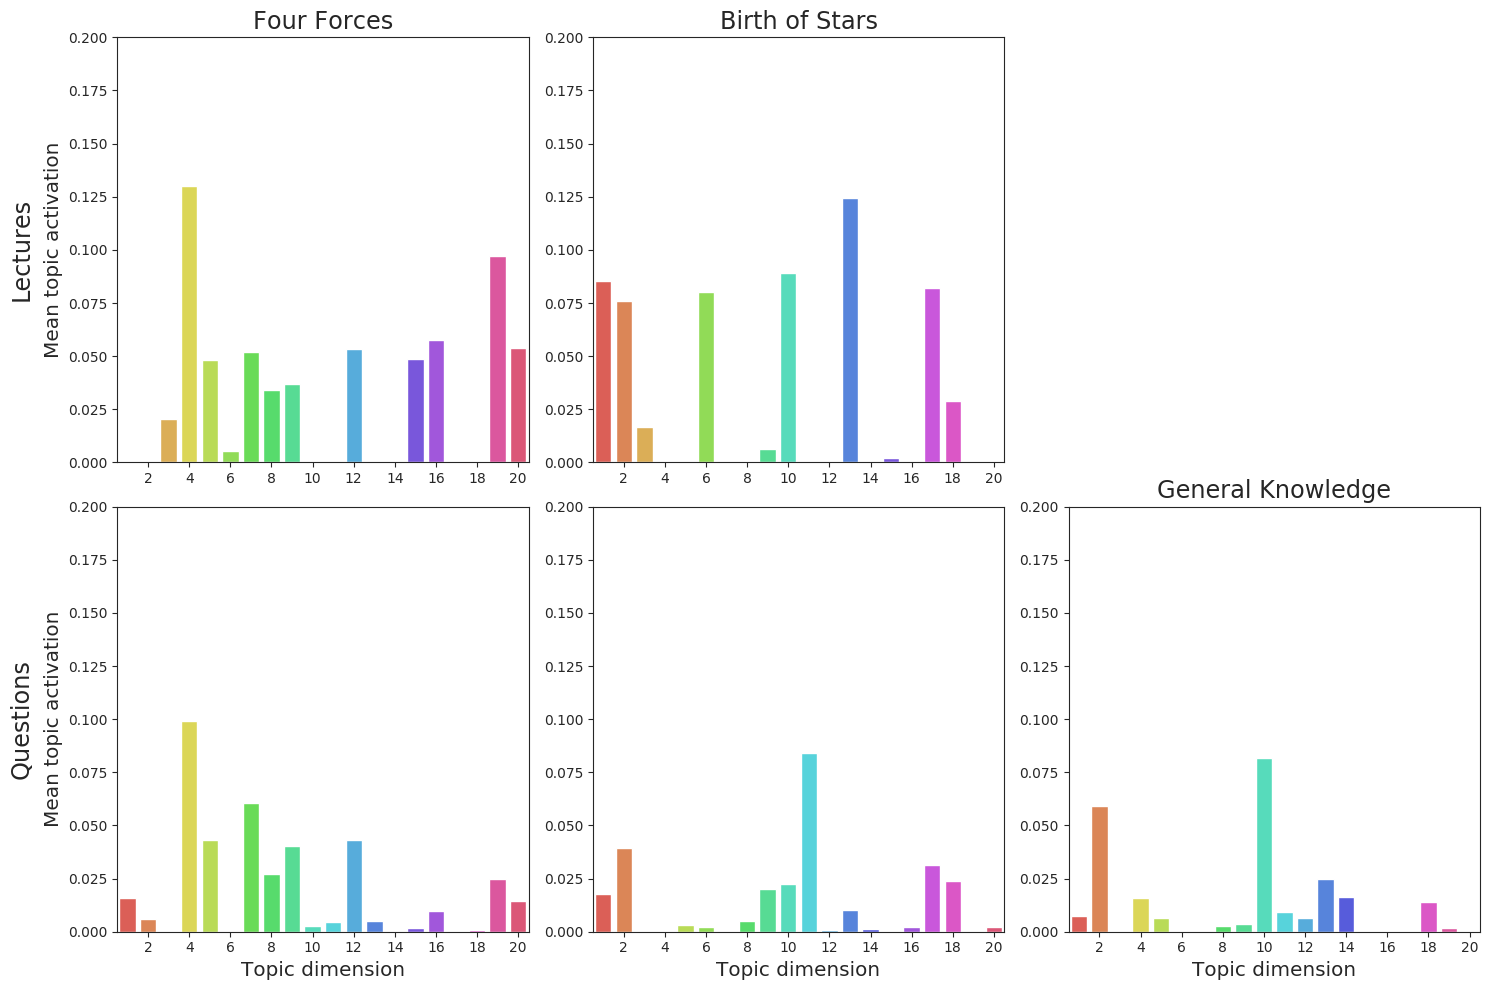

In [57]:
pm.plot_topics()

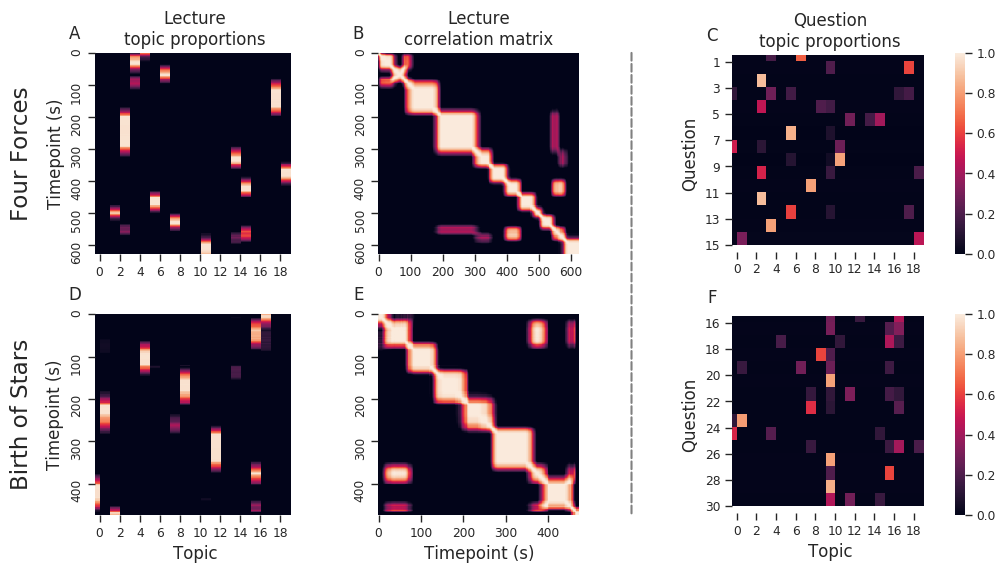

In [58]:
pm.plot_heatmaps()

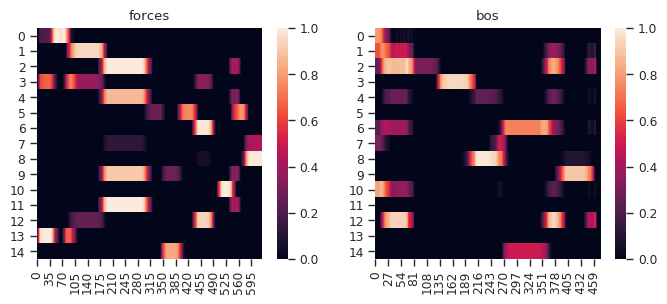

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap((1-cdist(pm.forces_traj, pm.forces_questions, 'correlation')).T, 
            vmin=0, vmax=1, ax=ax1)
ax1.set_title('forces')
sns.heatmap((1-cdist(pm.bos_traj, pm.bos_questions, 'correlation')).T, 
            vmin=0, vmax=1, ax=ax2)
ax2.set_title('bos')
plt.show()

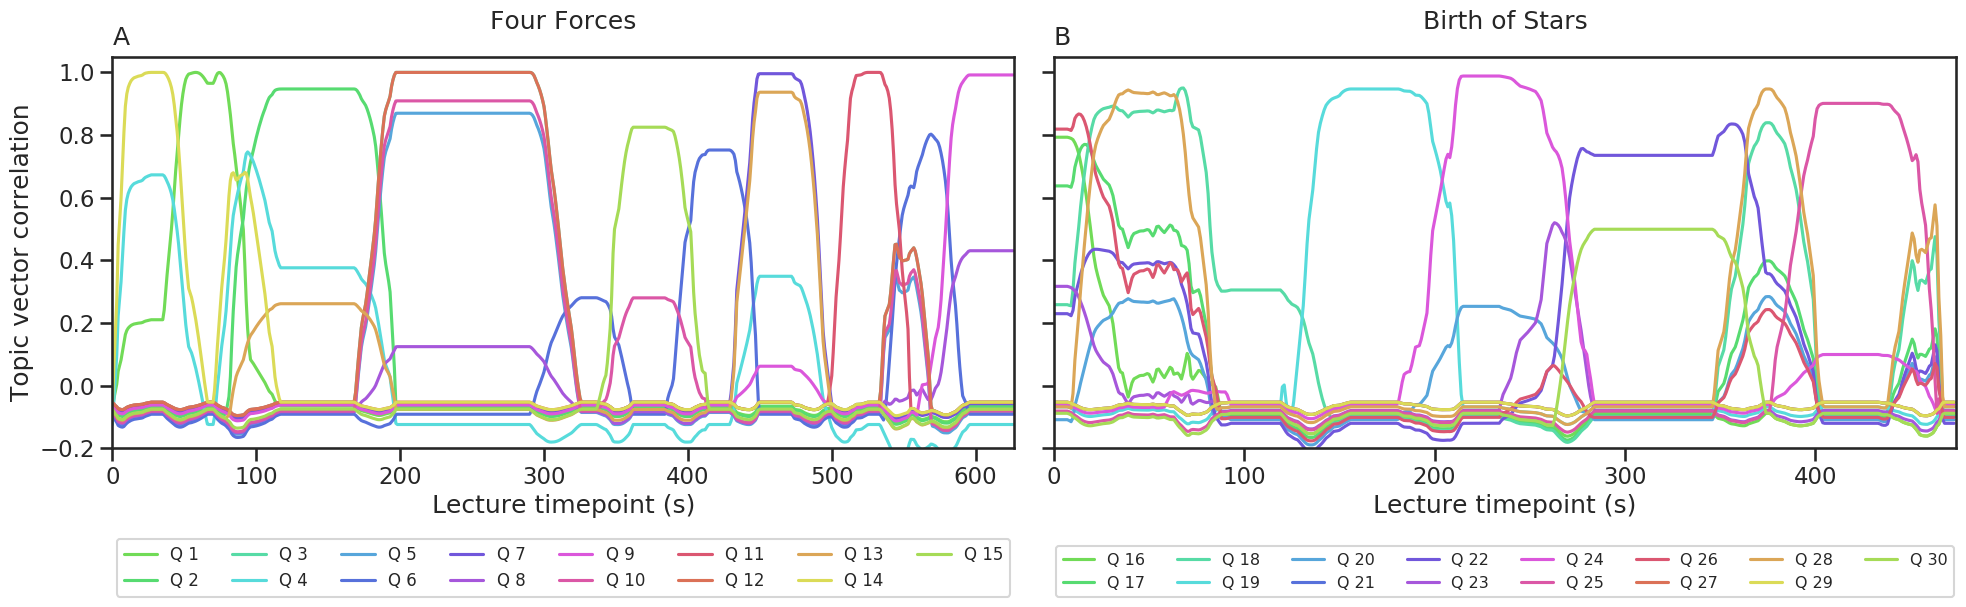

In [60]:
pm.plot_corr_timeseries()

/opt/conda/lib/python3.7/site-packages/hypertools/plot/plot.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


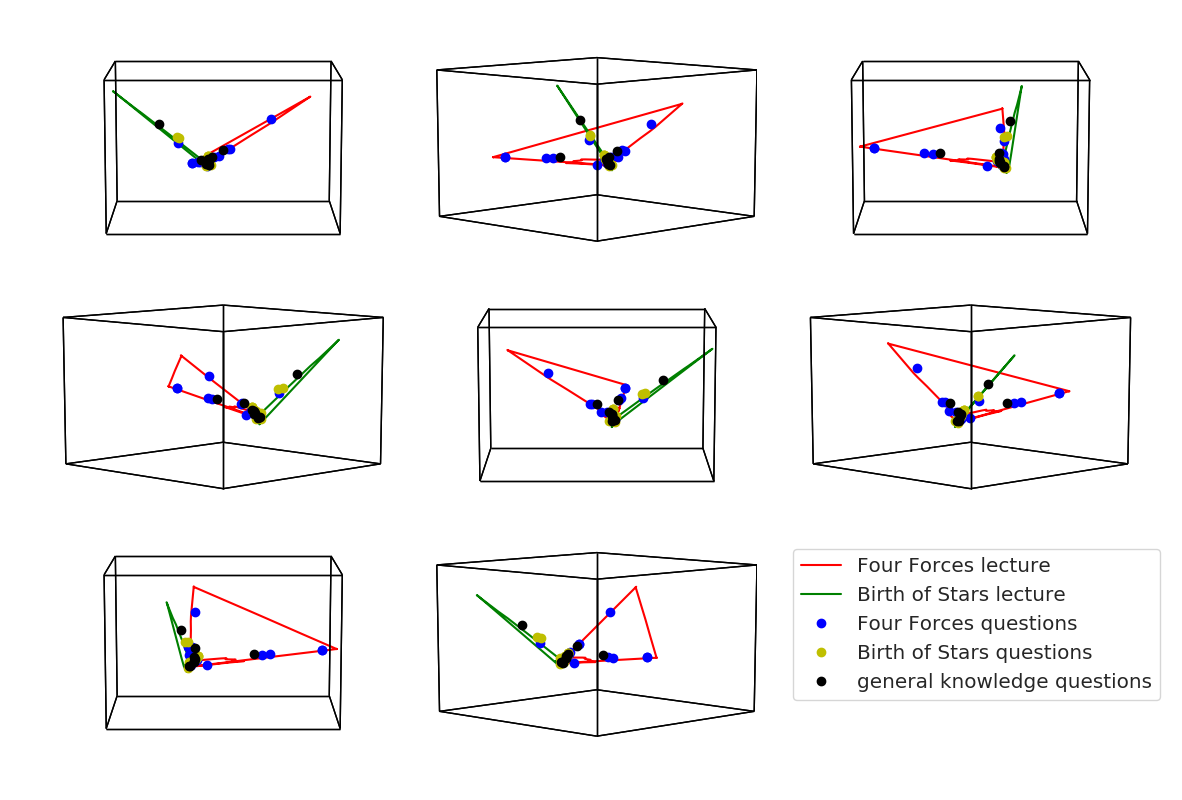

In [61]:
pm.plot_hypertools()

/opt/conda/lib/python3.7/site-packages/hypertools/plot/plot.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


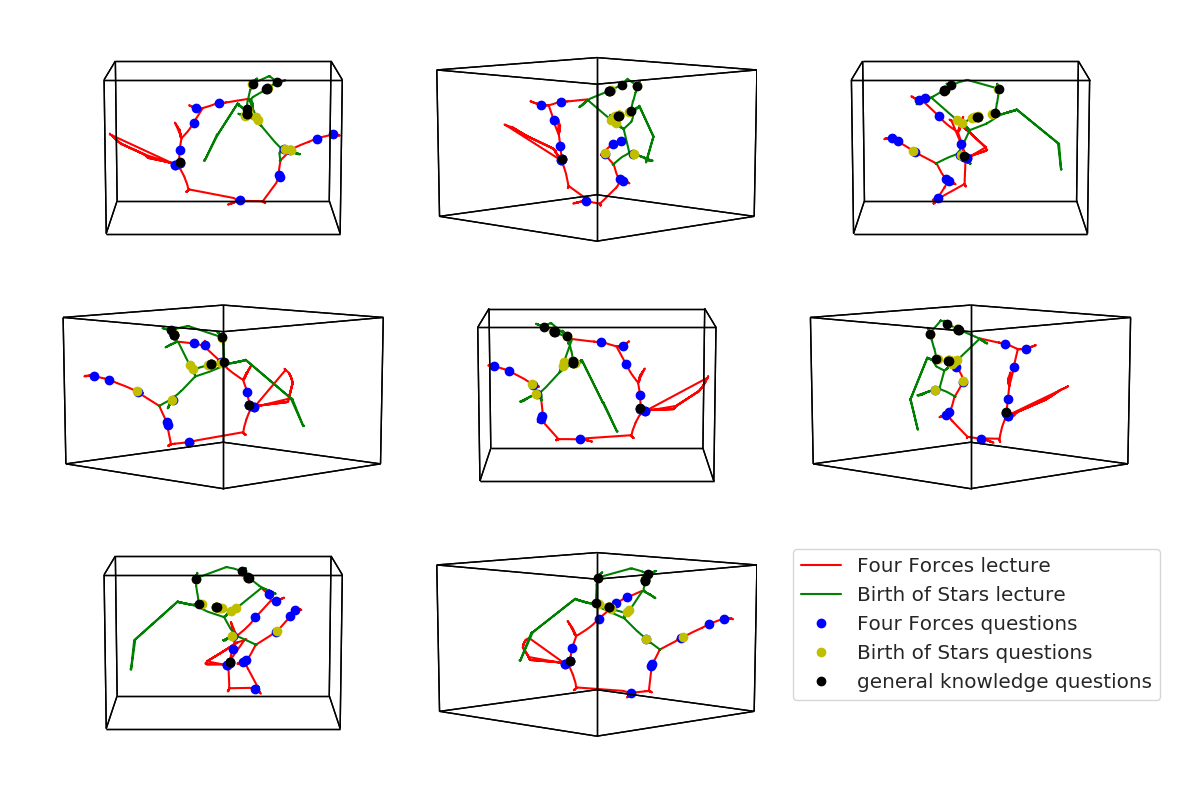

In [62]:
pm.plot_hypertools(reducer='UMAP')

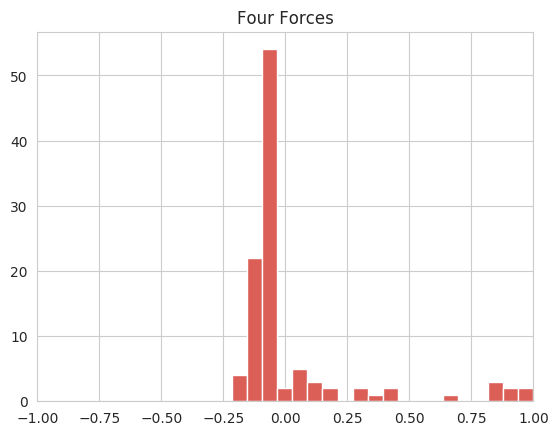

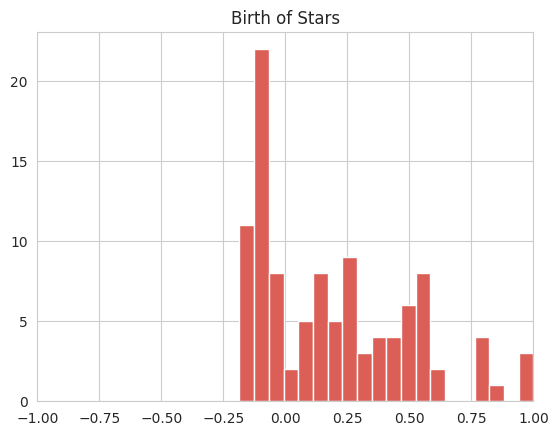

In [63]:
pm.plot_qcorr_dists()

In [64]:
for topic, words in get_top_words(pm.cv, pm.lda).items():
    print(f'topic {topic + 1}:\n\t{", ".join(words)}')

topic 1:
	threshold, fusion, mass, star, temperature, pressure, fuse, occur, sequence, main
topic 2:
	pressure, energy, mass, enough, ignition, result, little, proton, two, call
topic 3:
	force, coulomb, charge, next, happen, run, positive, electromagnetic, sometimes, explain
topic 4:
	force, gravity, weak, strong, apply, interaction, scale, relative, time, distance
topic 5:
	force, weak, keep, orbit, surprise, around, gravity, scale, start, earth
topic 6:
	atom, hydrogen, want, much, nucleus, give, happen, around, scale, neat
topic 7:
	electron, two, atom, nucleus, chemistry, helium, around, draw, may, well
topic 8:
	scale, see, gravity, gravitational, draw, attraction, force, less, small, repel
topic 9:
	strong, force, distance, together, interaction, electromagnetic, keep, small, outward, enough
topic 10:
	enough, force, two, close, coulomb, fuse, ignition, nucleus, proton, fusion
topic 11:
	follow, star, increase, density, galaxy, supermassive, describe, sun, pull, gravitational
to

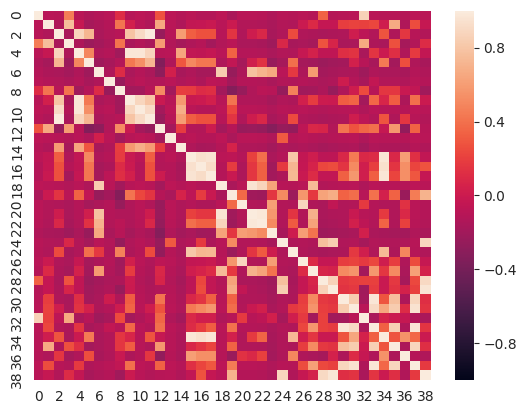

In [39]:
all_questions = np.concatenate((pm.forces_questions, pm.bos_questions, pm.gen_questions))
sns.heatmap(np.corrcoef(all_questions), vmin=-1, vmax=1)

In [231]:
all_words = ' '.join(ff_lines_processed + bos_lines_processed + quiz_text_processed.ravel().tolist()).split()
all_question_words = ' '.join(quiz_text_processed.ravel()).split()

In [232]:
from collections import Counter

wordcounts = Counter()
for word in all_words:
    wordcounts[word] += 1

In [233]:
wordcounts.most_common()

[('force', 90),
 ('atom', 54),
 ('mass', 50),
 ('gravity', 41),
 ('strong', 36),
 ('weak', 35),
 ('charge', 34),
 ('hydrogen', 32),
 ('interaction', 31),
 ('proton', 30),
 ('electromagnetic', 28),
 ('nucleus', 28),
 ('two', 26),
 ('small', 24),
 ('distance', 22),
 ('huge', 22),
 ('follow', 22),
 ('electron', 20),
 ('star', 20),
 ('temperature', 19),
 ('fusion', 19),
 ('neutron', 18),
 ('pressure', 18),
 ('keep', 16),
 ('large', 16),
 ('helium', 16),
 ('enough', 15),
 ('object', 15),
 ('fuse', 15),
 ('coulomb', 14),
 ('scale', 13),
 ('attraction', 13),
 ('together', 12),
 ('occur', 12),
 ('act', 12),
 ('sun', 11),
 ('way', 11),
 ('computer', 11),
 ('gravitational', 11),
 ('see', 11),
 ('different', 11),
 ('happen', 11),
 ('attract', 11),
 ('call', 10),
 ('well', 10),
 ('cloud', 10),
 ('dense', 10),
 ('universe', 9),
 ('start', 9),
 ('repel', 9),
 ('number', 9),
 ('time', 9),
 ('apply', 9),
 ('positive', 9),
 ('close', 9),
 ('energy', 9),
 ('around', 8),
 ('earth', 8),
 ('center', 8),
 (

In [78]:
from difflib import SequenceMatcher, get_close_matches

In [77]:
SequenceMatcher(None, 'especially', 'specially').ratio()

0.9473684210526315

In [91]:
for (w, l), c in manual_changes.items():
    if w in all_words:
        print(w)

positively


In [99]:
'positively' in ' '.join(quiz_text_processed.ravel().tolist()).split()

True

In [98]:
exp.questions.values[:, 1:].ravel().tolist()

['Why is the gravitational attraction between you and your computer too small for you to notice?',
 'Neither you nor your computer has enough mass to cause a noticable gravitational attraction',
 'You and your computer are too close for the gravitational attraction to be significant',
 'Humans are too small to detect the force of gravity',
 'The gravitational attraction between you and your computer is disrupted by the larger gravitational field generated by the earth',
 'Which of the following is an example of the Weak Interaction?',
 'A neutron in a radioactive Cesium atom is converted into a proton, leading to the release of a few particles',
 'Light from the sun collides with a satellite orbiting Earth and exerts a small push on the satellite',
 'Two protons bound together in a Helium nucleus resist separation despite a repulsive electromagnetic force acting on them',
 'A distant galaxy exerts a small but detectable gravitational pull on the  Earth',
 'Roughly how many times strong

In [96]:
quiz_text_processed.ravel().tolist()

['gravitational attraction computer small notice',
 'neither computer enough mass cause noticable gravitational attraction',
 'computer close gravitational attraction significant',
 'human small detect force gravity',
 'gravitational attraction computer disrupt large gravitational field generate earth',
 'follow example weak interaction',
 'neutron radioactive cesium atom convert proton lead release particle',
 'light sun collide satellite orbit earth exert small push satellite',
 'proton bound together helium nucleus resist separation despite repulsive electromagnetic force act',
 'distant galaxy exert small detectable gravitational pull earth',
 'rough many time strong weak interaction gravity',
 '',
 '',
 '',
 'weak interaction less strong gravity',
 'computer experience attraction repulsion due weak interaction',
 'weak interaction act extreme small distance',
 'weak interaction computer counteract force',
 'computer net charge',
 'neither computer enough mass induce significant we

In [75]:
manual_changes

defaultdict(int,
            {('actually', 'actual'): 27,
             ('surprising', 'surprise'): 2,
             ('exactly', 'exact'): 1,
             ('essentially', 'essential'): 2,
             ('completely', 'complete'): 1,
             ('strongest', 'strong'): 1,
             ('applies', 'apply'): 1,
             ('disappears', 'disappear'): 1,
             ('strongly', 'strong'): 1,
             ('especially', 'specially'): 1,
             ('operating', 'operate'): 1,
             ('atoms', 'atom'): 1,
             ('slowly', 'slow'): 6,
             ('denser', 'dense'): 8,
             ('condensing', 'condense'): 1,
             ('interesting', 'interest'): 1,
             ('happens', 'happen'): 1,
             ('obviously', 'obvious'): 2,
             ('positively', 'positive'): 1,
             ('slightly', 'slight'): 2,
             ('degrades', 'degrade'): 1,
             ('combined', 'combine'): 5,
             ('occurs', 'occur'): 3,
             ('eventually', 'eventual'

In [90]:
for word in wordcounts.keys():
    closest_matches = get_close_matches(word, wordcounts.keys(), n=4, cutoff=0.8)[1:]
    if len(closest_matches) > 0:
        print(word)
        print('\t', closest_matches)
        print()

start
	 ['star', 'state']

might
	 ['right', 'light']

way
	 ['away']

sense
	 ['dense']

molecular
	 ['molecule']

atomic
	 ['subatomic', 'atom']

attraction
	 ['attract', 'attractive']

notice
	 ['noticable']

magnet
	 ['magnetic', 'magnetism']

never
	 ['ever']

although
	 ['though']

interaction
	 ['interact']

either
	 ['neither']

neutron
	 ['neutrino']

detail
	 ['deal']

different
	 ['difference']

atom
	 ['atomic']

electron
	 ['electro', 'electrom']

neutrino
	 ['neutron']

away
	 ['way', 'anyway']

next
	 ['net']

anything
	 ['nothing']

come
	 ['become']

distance
	 ['distant']

deal
	 ['detail']

electromagnetism
	 ['electromagnetic']

electro
	 ['electron', 'electrom', 'electric']

magnetic
	 ['magnet', 'magnetism']

place
	 ['space']

electromagnetic
	 ['electromagnetism']

nothing
	 ['anything']

though
	 ['although']

electric
	 ['electricity', 'electro']

charge
	 ['charged', 'change']

magnetism
	 ['magnetic', 'magnet']

attractive
	 ['attract', 'attraction']

tend
	

In [87]:
word

'want'

In [13]:
cols = ['Number of topics', 'Lecture window length', 'Corpus', 'score']
gs_results = pd.DataFrame(columns=cols)
for ix, obj in enumerate(PARAM_MODELS):
    gs_results.loc[ix] = [obj.n_topics, obj.window_size, obj.corpus_key, obj.score]
    
# gs_results.to_pickle(DATA_DIR.joinpath('grid_search_results.p'))
# gs_results = pd.read_pickle(DATA_DIR.joinpath('grid_search_results.p'))

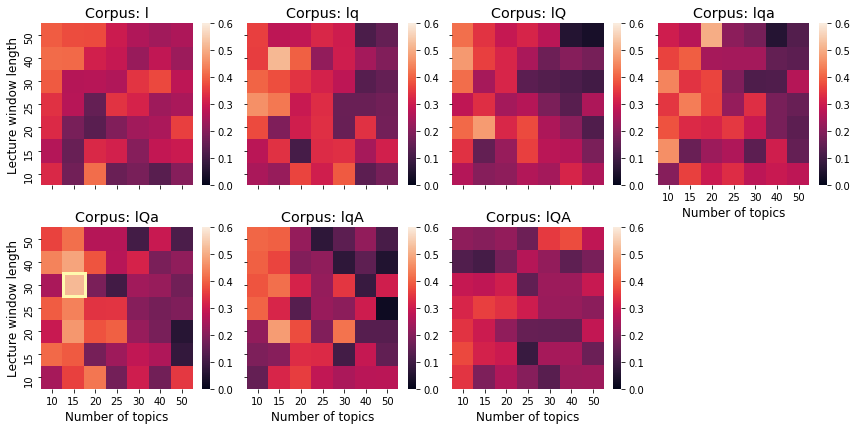

In [14]:
max_score = gs_results['score'].max()
g = sns.FacetGrid(gs_results, col='Corpus', col_wrap=4)
g.map_dataframe(corpus_heatmap, 
                'Number of topics', 
                'Lecture window length', 
                max_score, 
                vmin=0, 
                vmax=0.6)

g.set_titles('{col_var}: {col_name}', size='x-large')
g.set_xlabels(size='large')
g.set_ylabels(size='large')

# g.savefig(FIG_DIR.joinpath('parameter_search.pdf'), bbox_inches='tight')